# DonorsChoose.org - Clustering Solutions
***
<b>Class: </b>CMPE_257 Machine Learning <br>
<b>Team: </b>Vidhi Shah, Sithara KrishnaMurthy, Pragya Gautam, Reetika Goel <br>
***
<b>Business Objective:</b> <br>There is fantastic saying by Mother Teresa that says “It’s not how much we give but how much love we put into giving.”
In this age, technology has made it so much easier for everyone to give and by that it has helped millions of people globally. Donations can be made through a small text message or just a simple click of a button. The team at DonorsChoose.org does an amazing job to support the public education there by bringing classroom dreams to life for teachers and students all over United States.

Speaking about statistics, It has already raised $685 million through 3 million people and partners funding 1.1 million DonorsChoose.org projects. But teachers still spend more than a billion dollars of their own money on classroom materials. To get students what they need to learn and based on the data available regarding the donors, donations and classroom materials requirement, the organization would like to pair up donors to the classroom requests that will most motivate them to make an additional gift.

The email marketing campaigns will surely be able to connect donors with the projects that most inspires them and we “The Seekers” team, as data scientists or as machine learning engineers are ready to take up the challange to find and help them.<br><br>
<b>Kaggle Link:</b> https://www.kaggle.com/donorschoose/io/home

In [1]:
# import libraries
import pandas as pd
import numpy as np
from string import Template

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


##  Read CSVs
@Author: Team

In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# read csvs
df_donations = pd.read_csv("/content/drive/Team Drives/The Seekers - Machine Learning Project/DataSets/Donations.csv")
df_donors = pd.read_csv("/content/drive/Team Drives/The Seekers - Machine Learning Project/DataSets/Donors.csv")
df_projects = pd.read_csv("/content/drive/Team Drives/The Seekers - Machine Learning Project/DataSets/Projects.csv")

In [6]:
# print inital shapes for all csvs
print("Shape of Donations Data:",df_donations.shape,'\n')
print("Shape of Donors Data:",df_donors.shape,'\n')
print("Shape of Projects Data:",df_projects.shape,'\n')

Shape of Donations Data: (4687884, 7) 

Shape of Donors Data: (2122640, 5) 

Shape of Projects Data: (1110017, 18) 



In [7]:
df_projects['Project Current Status'].value_counts()

Fully Funded    826764
Expired         241402
Live             41851
Name: Project Current Status, dtype: int64

## Pre-Processing

<b>Null Check - Checking for columns with Null or Missing values in the datasets.</b>

In [8]:
# Checking the nulls count of given files

def null_check(df,name):
    print(name)
    print('Number of rows and cols are {} and {}'.format(df.shape[0],
            df.shape[1]))
    print('Number of nulls are \n{}'.format(df.isnull().sum()),'\n')
    

null_check(df_donations,'Donations')
null_check(df_donors,'Donors')
null_check(df_projects,'Projects')

Donations
Number of rows and cols are 4687884 and 7
Number of nulls are 
Project ID                             0
Donation ID                            0
Donor ID                               0
Donation Included Optional Donation    0
Donation Amount                        0
Donor Cart Sequence                    0
Donation Received Date                 0
dtype: int64 

Donors
Number of rows and cols are 2122640 and 5
Number of nulls are 
Donor ID                 0
Donor City          213097
Donor State              0
Donor Is Teacher         0
Donor Zip           180060
dtype: int64 

Projects
Number of rows and cols are 1110017 and 18
Number of nulls are 
Project ID                               0
School ID                                0
Teacher ID                               0
Teacher Project Posted Sequence          0
Project Type                             0
Project Title                            6
Project Essay                            1
Project Short Description      

<b>Mapping Categorical Values</b>
<font>Converting coulmns with text to numeric.<br/><br/><b> Donor Is Teacher </b><ul><li>No - 0</li><li>Yes - 1</li></ul><b>Project Type</b><br/> <ul><li>Teacher-Led - 1</li><li>Professional Development - 2</li><li>Student-Led - 3</li></ul></font>

In [0]:
df_donors['Donor Is Teacher']= df_donors['Donor Is Teacher'].map({'No':0,'Yes':1})
df_projects['Project Type']= df_projects['Project Type'].map({'Teacher-Led':1,'Professional Development':2,'Student-Led':3})

<b>Merging Donations + Donors + Projects + Schools to get all the donors with donations count >=2</b>

In [10]:
# Get the donations count per donor ID
donations_count = pd.DataFrame(
    df_donations.groupby("Donor ID")['Project ID'].count()
)

donations_count.reset_index(inplace = True)
donations_count.rename(columns = {'Project ID':'Donations_Count'},
                       inplace = True)
donations_count.head()

,Donor ID,Donations_Count
0,00000ce845c00cbf0686c992fc369df4,1
1,00002783bc5d108510f3f9666c8b1edd,1
2,00002d44003ed46b066607c5455a999a,11
3,00002eb25d60a09c318efbd0797bffb5,5
4,0000300773fe015f870914b42528541b,1


In [11]:
# Select target donors with donations count>= 2
target_donors = donations_count[donations_count['Donations_Count'] >= 2]

# For all the donors above get all information from donations csv and sort it by donation date desc

target_donations = df_donations[df_donations['Donor ID'].isin(target_donors['Donor ID'])]
target_donations = target_donations.sort_values('Donation Received Date', ascending=False)

# Drop duplicate values and populate target_donors with only Donor ID

target_donors = target_donations.drop_duplicates('Donor ID', keep='first')['Donor ID']
target_donors = target_donors.to_frame(name='Donor ID').reset_index()

# Select target projects : First merge target_donors and donations, get unique projects out of it to create 
                        # target_projects data frame. Finally get all the projects from df_projects that belongs 
                        # to target_projects

target_projects = target_donors.merge(target_donations, on='Donor ID')
target_projects = target_projects['Project ID'].unique()
target_projects = df_projects[df_projects['Project ID'].isin(target_projects)]

target_projects.head()

,Project ID,School ID,Teacher ID,Teacher Project Posted Sequence,Project Type,Project Title,Project Essay,Project Short Description,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,7685f0265a19d7b52a470ee4bac883ba,e180c7424cb9c68cb49f141b092a988f,4ee5200e89d9e2998ec8baad8a3c5968,25,1,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Did you know that 1-7 students in grades K-12 ...,"My students need 25 copies of ""Bullying in Sch...",Applied Learning,"Character Education, Early Development",Grades PreK-2,Technology,361.80,2013-01-01,2013-05-30,Fully Funded,2013-01-11
1,f9f4af7099061fb4bf44642a03e5c331,08b20f1e2125103ed7aa17e8d76c71d4,cca2d1d277fb4adb50147b49cdc3b156,3,1,Learning in Color!,"Help us have a fun, interactive listening cent...","Help us have a fun, interactive listening cent...","My students need a listening center, read alon...","Applied Learning, Literacy & Language","Early Development, Literacy",Grades PreK-2,Technology,512.85,2013-01-01,2013-05-31,Expired,NaN
2,afd99a01739ad5557b51b1ba0174e832,1287f5128b1f36bf8434e5705a7cc04d,6c5bd0d4f20547a001628aefd71de89e,1,1,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Visiting or moving to a new place can be very ...,My students need beginning vocabulary audio ca...,Literacy & Language,ESL,Grades PreK-2,Supplies,435.92,2013-01-01,2013-05-30,Fully Funded,2013-05-22
3,c614a38bb1a5e68e2ae6ad9d94bb2492,900fec9cd7a3188acbc90586a09584ef,8ed6f8181d092a8f4c008b18d18e54ad,40,1,Help Bilingual Students Strengthen Reading Com...,Students at our school are still working hard ...,Students at our school are still working hard ...,My students need one copy of each book in The ...,Literacy & Language,"ESL, Literacy",Grades 3-5,Books,161.26,2013-01-01,2013-05-31,Fully Funded,2013-02-06
4,ec82a697fab916c0db0cdad746338df9,3b200e7fe3e6dde3c169c02e5fb5ae86,893173d62775f8be7c30bf4220ad0c33,2,1,Help Us Make Each Minute Count!,"""Idle hands"" were something that Issac Watts s...","""Idle hands"" were something that Issac Watts s...","My students need items such as Velcro, two pou...",Special Needs,Special Needs,Grades 3-5,Supplies,264.19,2013-01-01,2013-05-30,Fully Funded,2013-01-01


In [12]:
# merged DataFrames
def merge_dataframes(source,dest,joincol):
    merged_df = source.merge(dest, on=joincol)
    print(merged_df.shape)
    return merged_df

merged_donation = merge_dataframes(target_donations,target_projects,'Project ID')
merged_donation = merge_dataframes(merged_donation,df_donors,'Donor ID')
# merged_donation_school = merge_dataframes(merged_donation,df_schools,'School ID')
merged_donor_donation = merge_dataframes(target_donations,df_donors,'Donor ID')

(3157585, 24)
(3156926, 28)
(3215610, 11)


## Linear Regression

In [0]:
def plotData(x,y,xlabel,ylabel):
  plt.figure(figsize=(10,8))
  plt.scatter(x, y,color='r')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(Template('$xlabel vs $ylabel').substitute(xlabel=xlabel, ylabel=ylabel))
  plt.show()
  
def TrainTestSplit(x,y):
  # Split the dataset into the training set and test set
  # We're splitting the data in 1/3, so out of 30 rows, 20 rows will go into the training set,
  # and 10 rows will go into the testing set.
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
  return xTrain, xTest, yTrain, yTest

def linearRegressionfunc(xTrain,yTrain,xTest):
  model = LinearRegression()
  model.fit(xTrain, yTrain)
  yPrediction = model.predict(xTest)
  return model,yPrediction

def plotModel(xTrain,yTrain,model,xlabel,ylabel):
  plt.figure(figsize=(10,8))
  plt.scatter(xTrain, yTrain, color = 'red')
  plt.plot(xTrain, model.predict(xTrain), color = 'blue')
  plt.title(Template('$xlabel vs $ylabel (Training set)').substitute(xlabel=xlabel, ylabel=ylabel))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  
def modelMetrics(model,xTest,yTest,yPrediction,x,y):
  print('Linear Regression Metrics')
  print('Intercept: %.4f' % model.intercept_) 
  print('Co-efficient: %.4f' % model.coef_)
  print('Mean Absolute Error: %.4f' % metrics.mean_absolute_error(yTest,yPrediction))
  print('Mean Squared Error: %.4f' % metrics.mean_squared_error(yTest,yPrediction))
  print('Root Mean Squared Error: %.4f' % np.sqrt(metrics.mean_squared_error(yTest,yPrediction)))
  print('R squared: %.4f' % model.score(xTest, yTest))
  print('Coefficient of determination R^2 of the prediction: %.4f' % model.score(x, y, sample_weight=None))
  
# https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/

def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = metrics.mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

def OLS_metrics(x,y):
  sm_constant = sm.add_constant(x)
  est = sm.OLS(y, sm_constant)
  est_fit = est.fit()
  print("P Value: %.4f" % est_fit.f_pvalue)
  print(est_fit.summary())

### 'Project Cost' vs 'Project Fund Collection Duration'
Objective: For a new project with cost "abc", how much duration it will take to get fully funded? <br>
Author: Reetika & Sithara


In [0]:
df_funded = merged_donation[merged_donation['Project Current Status'] == 'Fully Funded']

In [15]:
print(df_funded.shape)
df_funded.head(2)

(2859080, 28)


,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,School ID,Teacher ID,Teacher Project Posted Sequence,...,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,3344ecd911ff13ffda0b32da338b74c0,42ef86ed220158b1fcdd365a583ac3f2,eaf6f002a7294659b81cb8ce267f74ab,Yes,58.15,46,2018-05-09 11:38:47,ff493f0e3186d4f1609de6e14a91a535,3048f6daef1bd03c3eda34349961361e,1,...,Art Supplies,166.98,2018-04-26,2018-08-25,Fully Funded,2018-05-09,Chicago,Illinois,0,606
1,98bdd4883ebc5bd46b6fa13404c711a9,74ad0b53901f8dc67682f00716a322af,eaf6f002a7294659b81cb8ce267f74ab,Yes,29.10,45,2018-04-06 19:40:37,a2e5990cf57dd20a0a62696a8d62a829,02f7ba42f171beaae408151932f1afd3,27,...,Books,453.74,2018-03-28,2018-07-28,Fully Funded,2018-04-06,Chicago,Illinois,0,606


In [16]:
df_funded[df_funded['Project Posted Date'] <= df_funded['Project Fully Funded Date']].sort_values(by = 'Project ID',ascending=False )
df_fundedprojects = df_funded.filter(['Project ID','Project Cost','Project Posted Date','Project Fully Funded Date'], axis=1)

print(df_fundedprojects.shape)
print(df_fundedprojects.head(10))
df_fundedprojects = df_fundedprojects.drop_duplicates().reset_index(drop=True)
print(df_fundedprojects.shape)
df_fundedprojects.head(2)

(2859080, 4)
                         Project ID  Project Cost Project Posted Date  \
0  3344ecd911ff13ffda0b32da338b74c0        166.98          2018-04-26   
1  98bdd4883ebc5bd46b6fa13404c711a9        453.74          2018-03-28   
2  54c26a4484e9a1ac8c2026fa48ad8774        290.81          2018-03-30   
3  f3295b14b8bcd48f5845ba2a6e3c8dd3        206.74          2017-12-14   
4  5da7920b7a32b649aa6b911289edd5a4        251.59          2018-01-24   
5  f42a2d5b5cd36dca24d4d646f8f35d75        765.98          2018-01-25   
6  c03642724c17b6d40d4669ded9657065        393.51          2017-10-07   
7  e2ce6fd871fd2db3cdf5505de8f12461        441.18          2017-12-16   
8  bab3fd02dfd204a3abe42dca7670132a        756.24          2017-09-01   
9  2779e54073a00b1625ba90d7080542e3        375.98          2017-10-11   

  Project Fully Funded Date  
0                2018-05-09  
1                2018-04-06  
2                2018-04-06  
3                2018-01-25  
4                2018-01-25  
5  

,Project ID,Project Cost,Project Posted Date,Project Fully Funded Date
0,3344ecd911ff13ffda0b32da338b74c0,166.98,2018-04-26,2018-05-09
1,98bdd4883ebc5bd46b6fa13404c711a9,453.74,2018-03-28,2018-04-06


In [0]:
df_fundedprojects['Project Posted Date'] = pd.to_datetime(df_fundedprojects['Project Posted Date'])
df_fundedprojects['Project Fully Funded Date'] = pd.to_datetime(df_fundedprojects['Project Fully Funded Date'])

In [18]:
df_fundedprojects.dtypes

Project ID                           object
Project Cost                        float64
Project Posted Date          datetime64[ns]
Project Fully Funded Date    datetime64[ns]
dtype: object

In [19]:
df_fundedprojects['Project fund collection duration'] = df_fundedprojects['Project Fully Funded Date'] - df_fundedprojects['Project Posted Date']
df_fundedprojects = df_fundedprojects.sort_values('Project Cost')
df_fundedprojects.head()

,Project ID,Project Cost,Project Posted Date,Project Fully Funded Date,Project fund collection duration
272356,4cc71b179d2ff59bd4fb5e57f8a68fec,35.29,2015-09-12,2015-09-12,0 days
144811,f0b0b61a4ec15b9adc9ab1c13621dc5c,54.66,2015-09-04,2015-09-05,1 days
295675,16ae5343f00f4700bc9d0a4511992a6e,65.15,2014-03-19,2014-03-24,5 days
654900,da3fa84a177998b8f509c01faa354af1,65.15,2015-04-02,2015-04-02,0 days
303308,588d1a1acdd85e9408ffb8346c231cfa,73.91,2015-07-27,2015-08-22,26 days


In [20]:
df_fundedprojects['Project fund collection duration'] = df_fundedprojects['Project fund collection duration'].dt.days
df_fundedprojects.head()

,Project ID,Project Cost,Project Posted Date,Project Fully Funded Date,Project fund collection duration
272356,4cc71b179d2ff59bd4fb5e57f8a68fec,35.29,2015-09-12,2015-09-12,0
144811,f0b0b61a4ec15b9adc9ab1c13621dc5c,54.66,2015-09-04,2015-09-05,1
295675,16ae5343f00f4700bc9d0a4511992a6e,65.15,2014-03-19,2014-03-24,5
654900,da3fa84a177998b8f509c01faa354af1,65.15,2015-04-02,2015-04-02,0
303308,588d1a1acdd85e9408ffb8346c231cfa,73.91,2015-07-27,2015-08-22,26


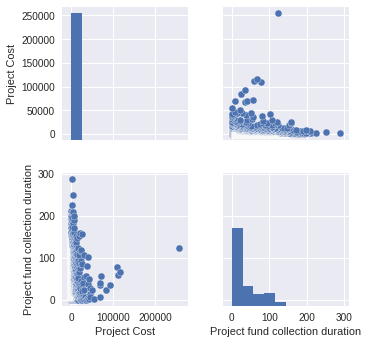

In [21]:
sns.pairplot(df_fundedprojects[['Project Cost','Project fund collection duration']], kind="scatter")
plt.show()

In [0]:
df_fundedprojects['Project Cost'] = df_fundedprojects['Project Cost'].astype(int)
df_fundedprojects['Project CostLog'] = df_fundedprojects['Project Cost'].apply(np.log)

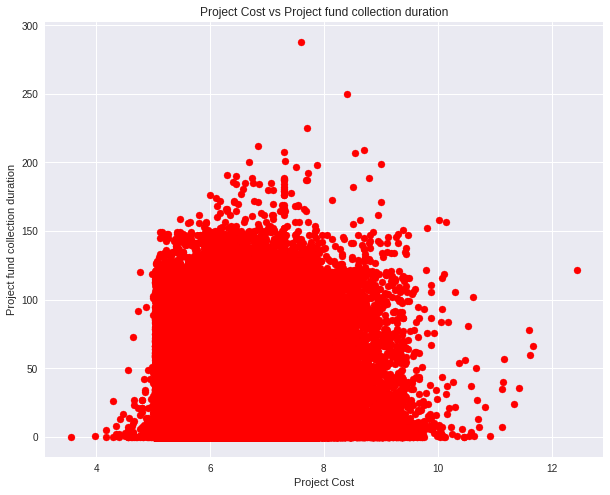

In [23]:
plotData(df_fundedprojects['Project CostLog'], df_fundedprojects['Project fund collection duration'],'Project Cost','Project fund collection duration')

In [0]:
dataset = df_fundedprojects[['Project Cost','Project fund collection duration']].reset_index(drop=True)
df_dataset = dataset[dataset['Project Cost'] <= 100000]

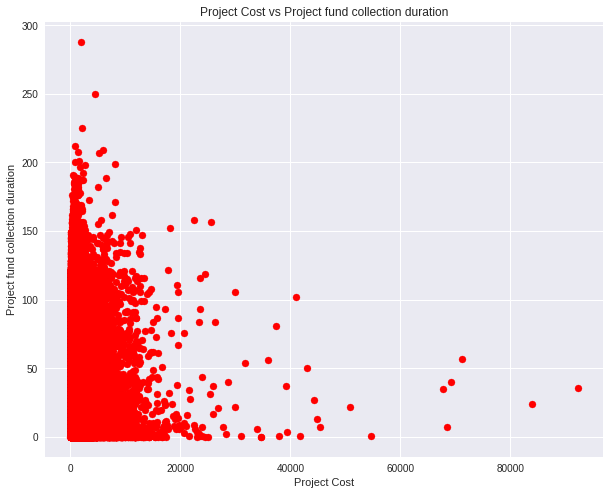

In [25]:
plotData(df_dataset['Project Cost'],df_dataset['Project fund collection duration'],'Project Cost','Project fund collection duration')

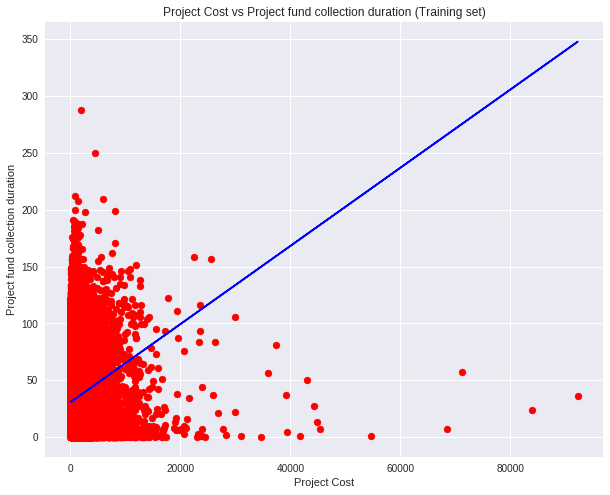

Linear Regression Metrics
Intercept: 30.4535
Co-efficient: 0.0034
Mean Absolute Error: 30.0573
Mean Squared Error: 1327.5634
Root Mean Squared Error: 36.4357
R squared: 0.0048
Coefficient of determination R^2 of the prediction: 0.0047


In [26]:
x1 = df_dataset.iloc[:, :-1].values
y1 = df_dataset.iloc[:, 1].values
x1Train, x1Test, y1Train, y1Test = TrainTestSplit(x1,y1)
linearRegressor1,y1Prediction = linearRegressionfunc(x1Train,y1Train,x1Test)
plotModel(x1Train,y1Train,linearRegressor1,'Project Cost','Project fund collection duration')
modelMetrics(linearRegressor1,x1Test,y1Test,y1Prediction,x1,y1)

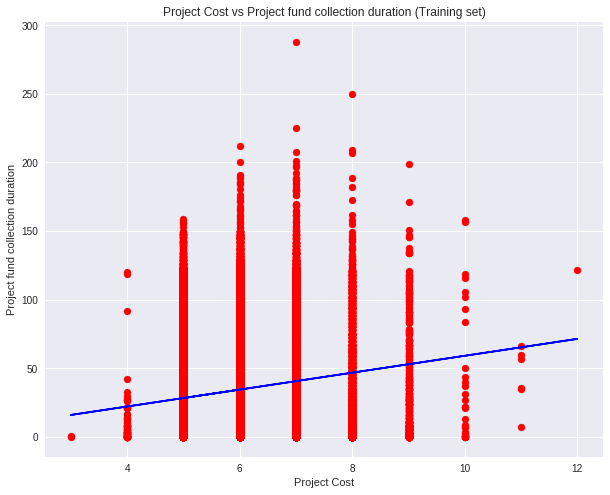

Linear Regression Metrics
Intercept: -2.4110
Co-efficient: 6.1600
Mean Absolute Error: 29.8747
Mean Squared Error: 1315.3113
Root Mean Squared Error: 36.2672
R squared: 0.0129
Coefficient of determination R^2 of the prediction: 0.0129


In [27]:
df_fundedprojects['Project CostLog'] = df_fundedprojects['Project CostLog'].astype(int)
logdataset = df_fundedprojects[['Project CostLog','Project fund collection duration']].reset_index(drop=True)
x1log = logdataset.iloc[:, :-1].values
y1log = logdataset.iloc[:, 1].values

x1Trainlog, x1Testlog, y1Trainlog, y1Testlog = TrainTestSplit(x1log,y1log)
linearRegressor1log,y1Predictionlog = linearRegressionfunc(x1Trainlog,y1Trainlog,x1Testlog)
plotModel(x1Trainlog,y1Trainlog,linearRegressor1log,'Project Cost','Project fund collection duration')
modelMetrics(linearRegressor1log,x1Testlog,y1Testlog,y1Predictionlog,x1log,y1log)

In [28]:
# https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/

train_error, test_error = calc_metrics(x1Train, y1Train, x1Test, y1Test, linearRegressor1)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

train error: 1317.723 | test error: 1327.563
train/test: 1.0


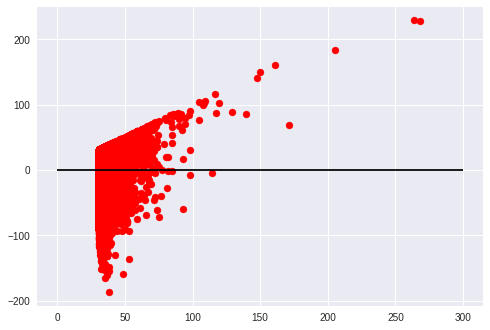

In [29]:
# https://towardsdatascience.com/linear-regression-detailed-view-ea73175f6e86

plt.scatter(y1Prediction,y1Prediction - y1Test, c='r')
plt.hlines(y=0,xmin=0,xmax=300)

In [30]:
# calculate Pearson's correlation
corr, _ = pearsonr(df_dataset['Project Cost'], df_dataset['Project fund collection duration'])
print('Pearsons correlation: %.3f' % corr)

corr, _ = spearmanr(df_dataset['Project Cost'], df_dataset['Project fund collection duration'])
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: 0.069
Spearmans correlation: 0.151


In [31]:
OLS_metrics(x1,y1)

P Value: 0.0000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3241.
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        03:31:52   Log-Likelihood:            -3.4258e+06
No. Observations:              683510   AIC:                         6.852e+06
Df Residuals:                  683508   BIC:                         6.852e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.4556      0.057    

### 'Project Cost' vs 'Donation Amount'
Objective : For a new project with cost "abc" what will be donation amount? <br>
Author: Vidhi & Pragya

In [0]:
df_LR2 = merged_donation[['Project ID','Project Cost','Donation Amount']].copy().sort_values(by='Project ID').reset_index(drop=True)

In [0]:
df_getdonationamt = df_LR2.groupby('Project ID')['Donation Amount'].sum().reset_index()

In [34]:
df_donationamt = pd.merge(df_LR2[['Project ID','Project Cost']],df_getdonationamt,on='Project ID').drop_duplicates()
print(df_donationamt.shape)
df_donationamt.head()

(812010, 3)


,Project ID,Project Cost,Donation Amount
0,000009891526c0ade7180f8423792063,529.68,223.37
3,00000ce845c00cbf0686c992fc369df4,710.07,260.00
6,00002d44003ed46b066607c5455a999a,737.85,597.92
14,00002eb25d60a09c318efbd0797bffb5,695.28,680.28
17,0000300773fe015f870914b42528541b,282.60,282.60


In [0]:
df_donationamtnew = df_donationamt[df_donationamt['Project Cost'] <= 20000]

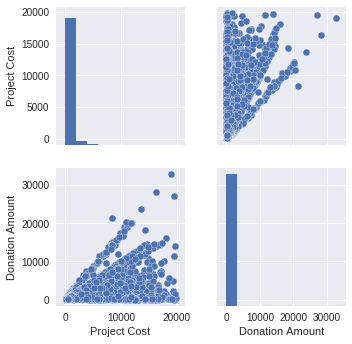

In [36]:
sns.pairplot(df_donationamtnew, kind="scatter")
plt.show()

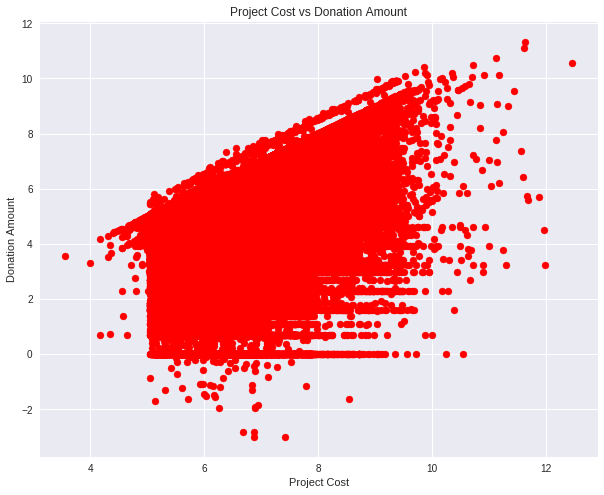

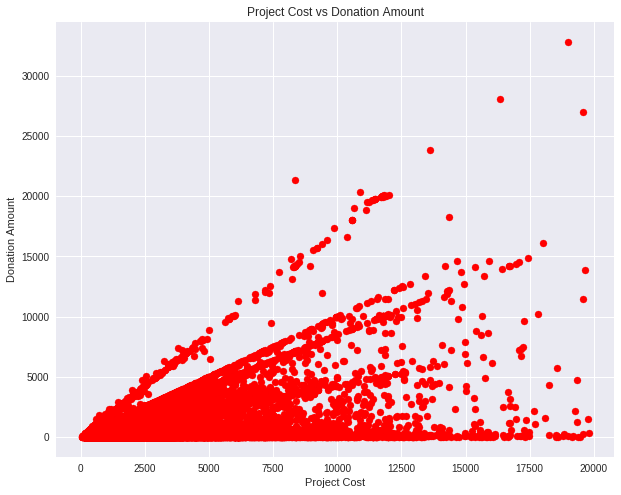

In [37]:
plotData(df_donationamt['Project Cost'].apply(np.log), df_donationamt['Donation Amount'].apply(np.log),'Project Cost','Donation Amount')
plotData(df_donationamtnew['Project Cost'], df_donationamtnew['Donation Amount'],'Project Cost','Donation Amount')

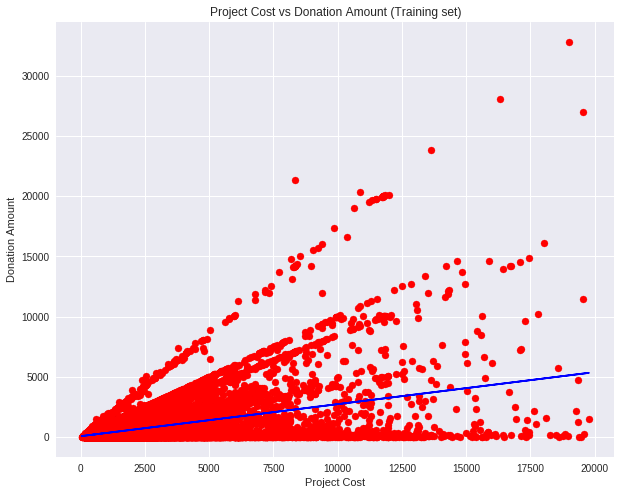

Linear Regression Metrics
Intercept: 72.6405
Co-efficient: 0.2657
Mean Absolute Error: 170.6920
Mean Squared Error: 109536.6044
Root Mean Squared Error: 330.9631
R squared: 0.2439
Coefficient of determination R^2 of the prediction: 0.2415


In [38]:
x4 = df_donationamtnew.iloc[:, 1:2].values
y4 = df_donationamtnew.iloc[:, 2:3].values
# Train-Test Split
x4Train, x4Test, y4Train, y4Test = TrainTestSplit(x4,y4)
linearRegressor4,y4Prediction = linearRegressionfunc(x4Train,y4Train,x4Test)
# Linear Regression
plotModel(x4Train,y4Train,linearRegressor4,'Project Cost','Donation Amount')
modelMetrics(linearRegressor4,x4Test,y4Test,y4Prediction,x4,y4)

In [39]:
train_error, test_error = calc_metrics(x4Train, y4Train, x4Test, y4Test, linearRegressor4)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

train error: 116437.685 | test error: 109536.604
train/test: 0.9


In [40]:
# calculate Pearson's correlation
corr, _ = pearsonr(df_donationamtnew['Project Cost'], df_donationamtnew['Donation Amount'])
print('Pearsons correlation: %.3f' % corr)

corr, _ = spearmanr(df_donationamtnew['Project Cost'], df_donationamtnew['Donation Amount'])
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: 0.491
Spearmans correlation: 0.248


In [41]:
OLS_metrics(x4,y4)

P Value: 0.0000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                 2.586e+05
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        03:32:48   Log-Likelihood:            -5.8792e+06
No. Observations:              811875   AIC:                         1.176e+07
Df Residuals:                  811873   BIC:                         1.176e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.6830      0.509    

### 'Median Household Income' vs 'Donation Amount'

Performing linear regression by Data Enhancement using the available dataset for Donor and new dataset with location wise population details.<br>
Objective: For a new househould income, what will be the donation amount? <br>
Author: Pragya & Vidhi

In [42]:
donor_zip = merged_donor_donation[['Donation Amount','Donor Zip']] 
print(donor_zip.shape)
donor_zip.head()

(3215610, 2)


,Donation Amount,Donor Zip
0,58.15,606
1,29.10,606
2,133.04,606
3,65.87,606
4,26.68,606


In [43]:
print(donor_zip.isnull().sum())
print('Replacing AlphaNumeric Zipcodes with NaN.')
donor_zip['Donor Zip'] = donor_zip['Donor Zip'].astype(str).replace('.*[a-zA-Z].*', np.NaN, regex=True)
print(donor_zip.isnull().sum())
print('Dropping null values in Zipcode column.')
donor_zip = donor_zip.dropna()
print(donor_zip.isnull().sum())

Donation Amount         0
Donor Zip          127757
dtype: int64
Replacing AlphaNumeric Zipcodes with NaN.
Donation Amount         0
Donor Zip          127860
dtype: int64
Dropping null values in Zipcode column.
Donation Amount    0
Donor Zip          0
dtype: int64


In [44]:
donor_zip['Donor Zip'] = donor_zip['Donor Zip'].astype(float).astype(int)
donor_zip = donor_zip[donor_zip['Donor Zip'].between(750, 799, inclusive=True)]
donor_zip.head(10)

,Donation Amount,Donor Zip
15678,70.00,758
15679,50.00,758
15680,58.14,758
15681,10.00,758
15682,50.00,758
15683,10.00,758
15684,100.00,758
15685,50.00,758
20532,25.00,785
20533,50.00,785


In [45]:
donor_zip_unique = (donor_zip.groupby(['Donor Zip'])
                   .agg({'Donation Amount':'sum'})
                   .reset_index())
donor_zip_unique.head()

,Donor Zip,Donation Amount
0,750,1305293.78
1,751,232413.25
2,752,954941.94
3,753,15748.93
4,754,78794.01


In [46]:
df_texas = pd.read_csv("/content/drive/Team Drives/Machine Learning/Project/DataSet/area_context_texas.csv")
df_texas.head()

,Housing Units,zipcode,Water Area,Median Home Value,Median Household Income,Population Density,Occupied Housing Units,Population,id,Land Area
0,8102,75001,0.00,258200,57633,3237,7088,12414,750,3.83
1,21373,75002,2.06,186100,91632,1699,20708,63140,750,37.16
2,17747,75006,0.25,146800,56985,2746,16631,46364,750,16.89
3,19296,75007,0.22,169400,78934,4433,18514,51624,750,11.65
4,3074,75009,1.57,190500,87581,92,2812,8785,750,95.42


In [47]:
df_texas = (df_texas.groupby(['id'])
                   .agg({'Median Household Income':'mean'})
                   .reset_index())
df_texas.rename(columns={'id': 'Donor Zip'}, inplace=True)                 
df_texas.head()

,Donor Zip,Median Household Income
0,750,75366.881356
1,751,52060.653846
2,752,48664.122449
3,753,0.000000
4,754,45543.222222


In [48]:
df_donorzip_texas = pd.merge(df_texas[['Donor Zip','Median Household Income']],donor_zip_unique,on='Donor Zip')
print(df_donorzip_texas.shape)
df_donorzip_texas.head()

(49, 3)


,Donor Zip,Median Household Income,Donation Amount
0,750,75366.881356,1305293.78
1,751,52060.653846,232413.25
2,752,48664.122449,954941.94
3,753,0.000000,15748.93
4,754,45543.222222,78794.01


In [49]:
df_donorzip_texas=df_donorzip_texas[(df_donorzip_texas['Median Household Income']>0) & (df_donorzip_texas['Donation Amount']<1000000)]
print(df_donorzip_texas.shape)
df_donorzip_texas.head()

(45, 3)


,Donor Zip,Median Household Income,Donation Amount
1,751,52060.653846,232413.25
2,752,48664.122449,954941.94
4,754,45543.222222,78794.01
5,755,37618.913043,24654.30
6,756,43377.684211,87261.45


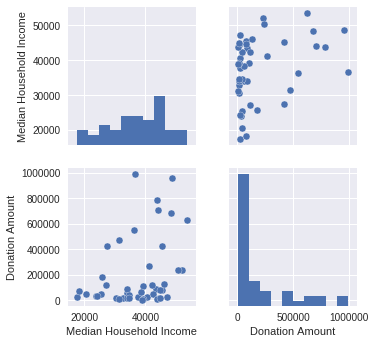

In [50]:
sns.pairplot(df_donorzip_texas[['Median Household Income','Donation Amount']], kind="scatter")
plt.show()

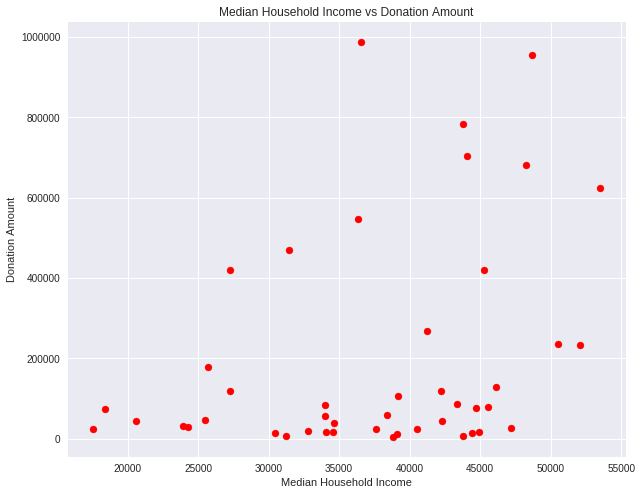

In [51]:
plotData(df_donorzip_texas['Median Household Income'], df_donorzip_texas['Donation Amount'],'Median Household Income','Donation Amount')

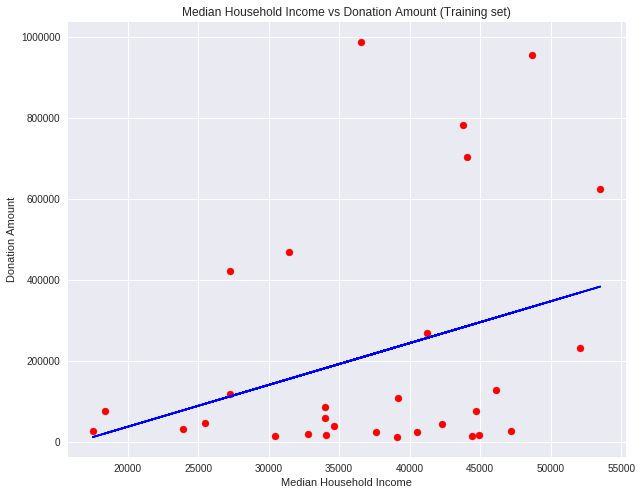

Linear Regression Metrics
Intercept: -170406.4677
Co-efficient: 10.3440
Mean Absolute Error: 174512.4016
Mean Squared Error: 39568521366.4581
Root Mean Squared Error: 198918.3787
R squared: 0.0753
Coefficient of determination R^2 of the prediction: 0.1035


In [52]:
x2 = df_donorzip_texas.iloc[:,1 :2].values
y2 = df_donorzip_texas.iloc[:,2:3 ].values
# Train-Test Split
x2Train, x2Test, y2Train, y2Test = TrainTestSplit(x2,y2)
# Linear Regression
linearRegressor2,y2Prediction = linearRegressionfunc(x2Train,y2Train,x2Test)
plotModel(x2Train,y2Train,linearRegressor2,'Median Household Income','Donation Amount')
modelMetrics(linearRegressor2,x2Test,y2Test,y2Prediction,x2,y2)

In [53]:
train_error, test_error = calc_metrics(x2Train, y2Train, x2Test, y2Test, linearRegressor2)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

train error: 77836544672.143 | test error: 39568521366.458
train/test: 0.5


In [54]:
# calculate Pearson’s correlation
corr, _ = pearsonr(df_donorzip_texas['Median Household Income'], df_donorzip_texas['Donation Amount'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.329


In [55]:
OLS_metrics(x2,y2)

P Value: 0.0273
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     5.220
Date:                Wed, 06 Mar 2019   Prob (F-statistic):             0.0273
Time:                        03:32:56   Log-Likelihood:                -623.96
No. Observations:                  45   AIC:                             1252.
Df Residuals:                      43   BIC:                             1256.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.691e+05   1.66e+05    

### 'Housing Unit' vs 'Population'
From the new data set i.e. enrichment data set, identify linear relationship.<br>
Objective: For a given population, how many housing units are predicted to be occupied?<br>
Author: Sithara & Pragya

In [56]:
df_texasData = pd.read_csv("/content/drive/Team Drives/Machine Learning/Project/DataSet/area_context_texas.csv")
df_texasData.head(2)

,Housing Units,zipcode,Water Area,Median Home Value,Median Household Income,Population Density,Occupied Housing Units,Population,id,Land Area
0,8102,75001,0.00,258200,57633,3237,7088,12414,750,3.83
1,21373,75002,2.06,186100,91632,1699,20708,63140,750,37.16


In [57]:
df_texasData.isnull().sum()

Housing Units              0
zipcode                    0
Water Area                 0
Median Home Value          0
Median Household Income    0
Population Density         0
Occupied Housing Units     0
Population                 0
id                         0
Land Area                  0
dtype: int64

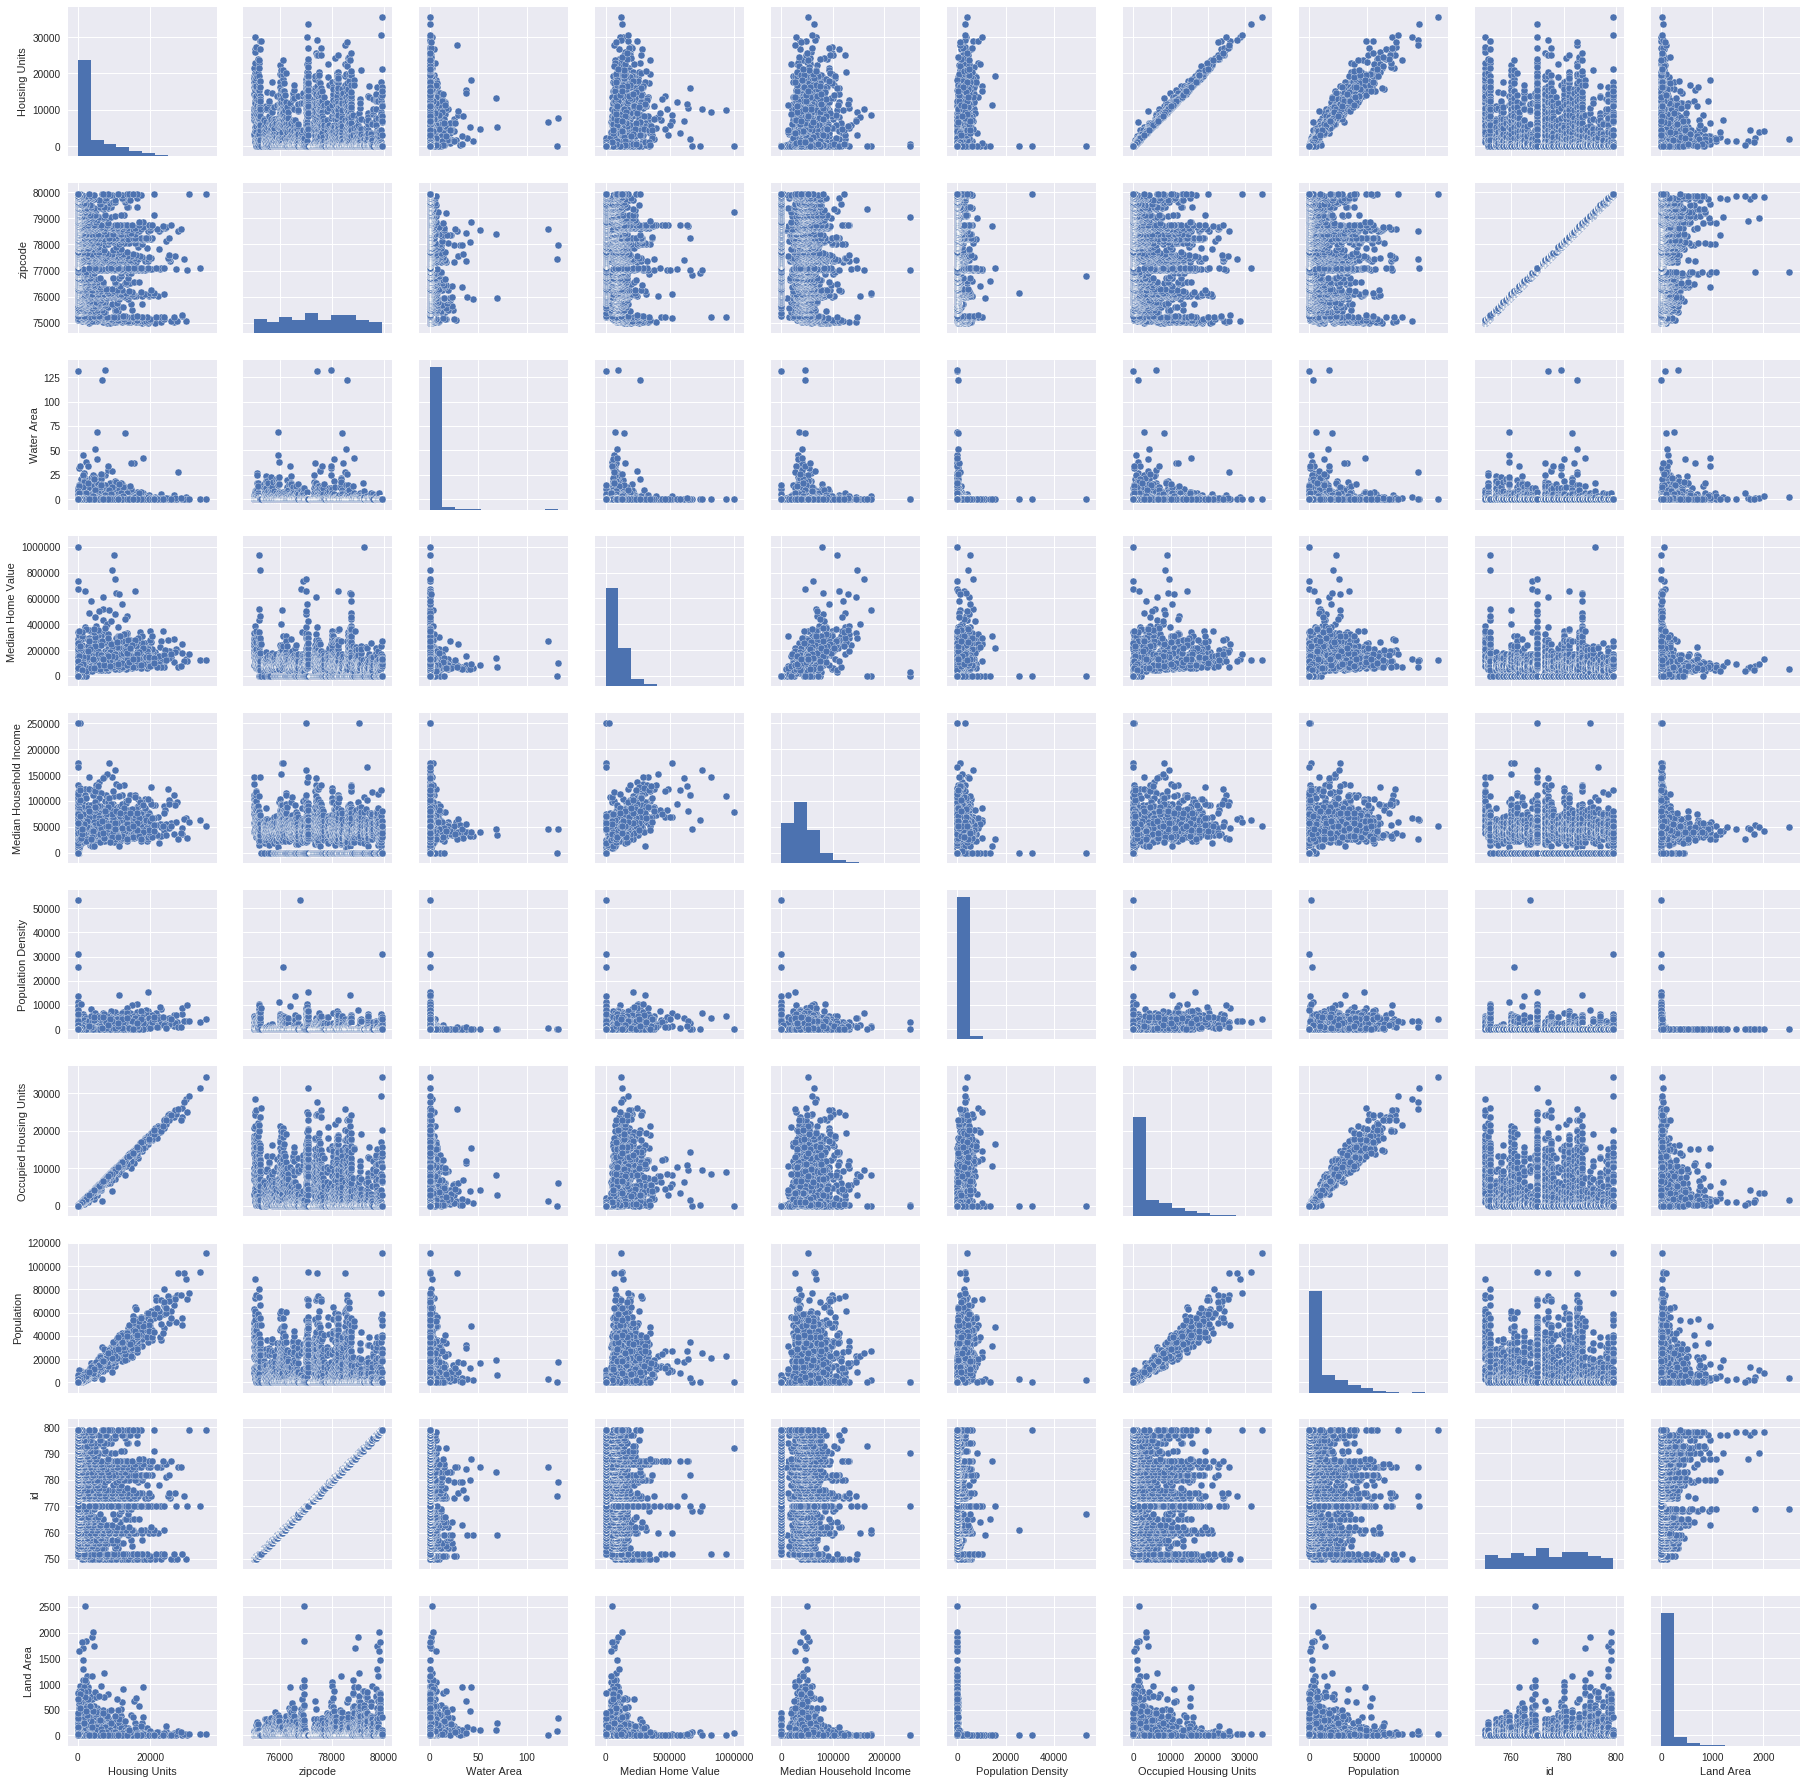

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
 
#without regression
sns.pairplot(df_texasData, kind="scatter")
plt.show()

In [59]:
df_donorzip_all = pd.merge(df_texas,donor_zip_unique,on='Donor Zip')
print(df_donorzip_all.shape)
df_donorzip_all.head()

(49, 3)


,Donor Zip,Median Household Income,Donation Amount
0,750,75366.881356,1305293.78
1,751,52060.653846,232413.25
2,752,48664.122449,954941.94
3,753,0.000000,15748.93
4,754,45543.222222,78794.01


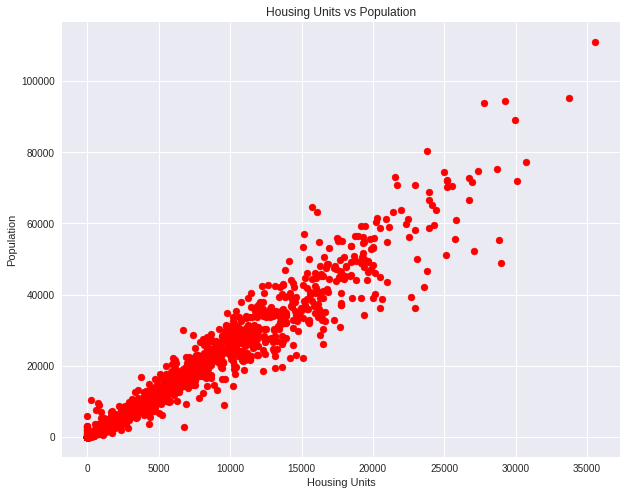

In [60]:
plotData(df_texasData['Housing Units'], df_texasData['Population'],'Housing Units','Population')

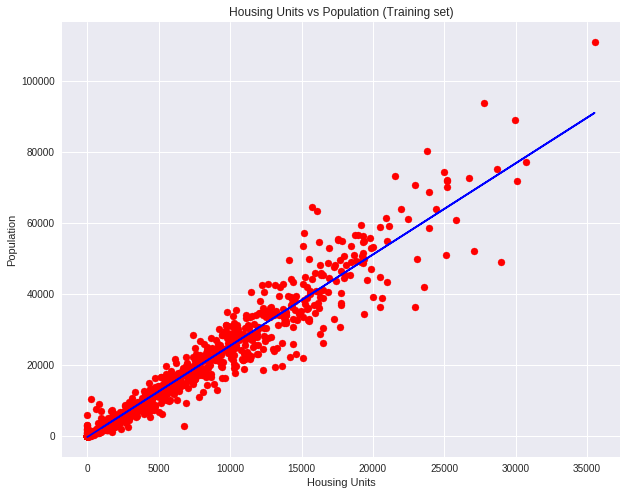

Linear Regression Metrics
Intercept: -258.7643
Co-efficient: 2.5701
Mean Absolute Error: 1469.1176
Mean Squared Error: 8696181.4893
Root Mean Squared Error: 2948.9289
R squared: 0.9646
Coefficient of determination R^2 of the prediction: 0.9568


In [61]:
x3 = df_texasData.iloc[:,0].values
y3 = df_texasData.iloc[:,7].values
# Train-Test Split
x3Train, x3Test, y3Train, y3Test = TrainTestSplit(x3,y3)
x3Train = x3Train.reshape(-1, 1)
x3Test = x3Test.reshape(-1, 1)
# Linear Regression
linearRegressor3,y3Prediction = linearRegressionfunc(x3Train,y3Train,x3Test)
plotModel(x3Train,y3Train,linearRegressor3,'Housing Units','Population')
modelMetrics(linearRegressor3,x3Test,y3Test,y3Prediction,x3.reshape(-1, 1),y3)

In [62]:
train_error, test_error = calc_metrics(x3Train, y3Train, x3Test, y3Test, linearRegressor3)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

train error: 11182564.796 | test error: 8696181.489
train/test: 0.8


In [63]:
# calculate Pearson’s correlation
corr, _ = pearsonr(df_texasData['Housing Units'], df_texasData['Population'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.978


In [64]:
OLS_metrics(x3,y3)

P Value: 0.0000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                 5.335e+04
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        03:33:16   Log-Likelihood:                -22864.
No. Observations:                2408   AIC:                         4.573e+04
Df Residuals:                    2406   BIC:                         4.574e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -206.7412     80.173    

<div class="alert alert-block alert-info">

---


### Linear Regression Insights:
---
We implemented linear regression techniques on 4 different sets of features (one at a time) and have below findings from the same:

1. Firstly, we applied regression on 'Project Cost' and 'Donation Amount' features to predict what will be donation amount, for a new project with cost "abc". But then we saw that they have very less linear relationship . The same can also be concluded from correlation coefficients for it which are <0.5.

2. Secondly, we identified a LATENT VARIABLE i.e. "Project Fund Collection Duration". It is the time duration for a project to collect the total project cost. We used it in a regression model to predict how much duration it will take to get fully funded for a new project with cost "abc". Here also we saw very less linear relationship and a correlation coefficient <0.5

3. Thirdly,  we merged the enrichment dataset i.e. texas housing prices infomation with Donorschoose dataset over the zip code column with the objective of predicting donation amount contribution given a median household income of the area. Linear regression plot shows a good "best-fit line" here. However, the correlation co-efficient value is still <0.5

4. Because we were not getting a good linear relationship so far, we tried and applied linear regression algorithm on enrichment dataset itself i.e. between 'Housing Unit' and 'Population' to predict how many housing units will be occupied, for a given population. Here we achieved a very good "best-fit line" as well correlation co-efficient of 0.978

**Improvement Areas and Next Steps:**

As we couldn't find linear relationship between the numeric variables from our dataset, we tried converting text (E.g. Project Title/Category) into numeric data. However, due to very large amount of datapoints, we are not getting the desired results. We are working on the same.

Thank You! 